Code for generating heatmaps used as figures, for species relative abundance data as well as blood biomarker concentration data.

Author: Libby Reeves

Date: 06/22/21

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(font_scale=0.75)

In [2]:
def get_data_df(sample_type, tax_rank):
    """
    Reads in the data from its file. Removes unwanted columns.

    Inputs:
        - sample_type: a string indicating fecal or saliva sample
        - tax_rank: a string indicating species, genus, or family level

    Returns: a dataframe containing the data
    """

    filename = f"./football19_data/abundance_spreadsheets/percent_dropped/" \
               f"{sample_type}_{tax_rank}_percent_dropped.tsv"
    dataframe = pd.read_csv(filename, delimiter="\t")
    dataframe.drop(columns=["taxRank", "taxID", "Max", "lineage"], inplace=True)
    dataframe.rename(columns={"name": tax_rank}, inplace=True)
    dataframe.set_index(tax_rank, inplace=True)
    dataframe = dataframe.astype(float).fillna(0)
    return dataframe


def get_metadata_df(sample_type):
    """
    Reads in relevant metadata from its file.

    Inputs:
        - sample_type: a string identifying whether the sample is fecal or saliva

    Returns a dataframe of metadata for subsetting and plotting the data
    """
    metadata_file = f"./football19_data/metadata/{sample_type}_metadata.csv"
    dataframe = pd.read_csv(metadata_file)
    dataframe.rename(columns={"Unnamed: 0": "sample"}, inplace=True)
    dataframe.set_index("sample", inplace=True)

    # add a column indicating whether player had diagnosed concussion
    conc_samples = dataframe["group"].str.contains('Concussion')
    dataframe["conc player"] = conc_samples

    return dataframe


def get_sig_species_list(comparison, file='./football19_data/significant_species_spreadsheets/'
                                          'significant_species.csv', tax_rank="species"):
    """
    Gets the list of taxa which differed significantly across two timepoints or groups when
    compared. E.g. if comparison is "longitudinal_off", gets the list of taxa which differed
    significantly between post and off-season timepoints.

    Inputs:
        - comparison: a string identifying the two timepoints or groups which were compared
        - file: the file containing the list of significant species
        - tax_rank: a string identifying the taxonomic rank of interest (species by default)

    Returns: a list of strings; each string identifies a species, genus, or family which differed
    significantly between the compared groups/timepoints
    """
    sig_df = pd.read_csv(file)
    string = sig_df.loc[sig_df["comparison"] == comparison, tax_rank].iloc[0]
    species = [item.strip() for item in string.split(';')]
    return species


def sort_by_abs_value(dataframe):
    """
    Sorts a dataframe by average absolute value of values, in descending order by row.
    Returns a copy of the original dataframe, sorted.

    Inputs:
        - dataframe: a dataframe containing numerical data
    """
    new_df = dataframe.copy()
    # find the sum of absolute values of elements, across each row, and add it as a new column
    new_df["abs_avg_col"] = new_df.apply(lambda x: sum([abs(elem) for elem in x]), axis=1)

    # sort by that column, then remove it from dataframe and return the sorted dataframe
    new_df = new_df.sort_values(by="abs_avg_col", ascending=False)
    new_df = new_df.drop("abs_avg_col", axis=1)
    return new_df


def sort_by_some_cols(dataframe, group_cols):
    """
    Sorts a dataframe by the average of a subset of its columns.

    Inputs:
        - dataframe: the dataframe to be sorted
        - group_cols: the list of columns which we want to use to sort the dataframe

    Returns a new dataframe, containing the same data as the input, but sorted by the specified
    columns
    """
    new_df = dataframe.copy()
    new_df["avg_col"] = new_df[group_cols].mean(axis=1)
    new_df = new_df.sort_values(by="avg_col", ascending=False)
    new_df = new_df.drop("avg_col", axis=1)
    return new_df


def abundance_change(dataframe, players, former, latter, use_log=False):
    """
    Creates a dataframe of abundance changes, for each player in players, from the
    former timepoint to the latter timepoint.
    If a player does not have both timepoints, that player is excluded.
    By default, does not use log fold change; if use_log is set to true, uses log2 fold change.
        --> if necessary, will convert any 0 values to 0.000001 to avoid NaN and other errors.

    Inputs:
        - dataframe: dataframe with numerical data
        - players: a list of strings with players' numerical identifiers
        - former: string identifying the former timepoint (e.g. 'mid', 'post', 'off')
        - latter: string identifying the latter timepoint (e.g. 'mid', 'post', 'off')
        - use_log: flag for whether the log2fold change in percent relative abundance
          should be used. Default False, so absolute change is used.

    Returns: a new dataframe, containing the change (absolute, or log2fold) from former to latter
    timepoint, for each player in players which had both timepoints.
    """
    # get a list of all relevant column names in the dataframe
    former_cols = [f"{former}_{current_player}" for current_player in players]
    latter_cols = [f"{latter}_{current_player}" for current_player in players]
    all_cols = []
    for col in former_cols:
        if col in dataframe.columns:
            all_cols.append(col)
    for col in latter_cols:
        if col in dataframe.columns:
            all_cols.append(col)

    # get a sub-dataframe with only these columns
    sub_df = dataframe[all_cols]

    # create new empty dataframe
    change_df = pd.DataFrame()

    # for each player, if they have both timepoints' samples, get the change and add to new df
    for current_player in players:
        former_col = f"{former}_{current_player}"
        latter_col = f"{latter}_{current_player}"
        if former_col in sub_df.columns and latter_col in sub_df.columns:

            if use_log:  # by default: latter - former (absolute change)
                # replace all zero values with 0.000001 to avoid NaN with log fold change
                sub_df = sub_df.replace(0.0, 0.000001)
                diffs = np.log2(sub_df[latter_col] / sub_df[former_col])
            else:
                diffs = sub_df[latter_col] - sub_df[former_col]

            # add the new column to the dataframe of changes
            # column name: "playerID_{first letter of former}{first letter of latter}"
            change_df[f'{former[0]}{latter[0]}_{current_player}'] = diffs

    return change_df


def consolidated_df(dataframe, columns, name):
    """
    Consolidates a dataframe of individual columns into a new dataframe of just one column, where
    that single column contains the mean of the specified columns in the input dataframe.

    Inputs:
        - dataframe: dataframe with numeric data
        - columns: list of column names to be included in the mean column
        - name: name of the single column in the resulting dataframe

    Returns a dataframe containing a single column obtained by taking the average of the specified
    columns from input dataframe; the name of this column is specified by name
    """
    # select the subset of columns
    copy_df = dataframe.copy()[columns]

    # create a new empty dataframe
    new_df = pd.DataFrame()

    # add to new_df a single column with name "name" as the mean of columns of copy_df
    new_df[name] = copy_df.mean(axis=1)
    return new_df


def log_fold_change_2col(dataframe_in, dataframe_off):
    """
    Takes in a dataframe of in-season samples and off-season samples; calculates the difference
    between concussed and non-concussed players for in-season samples and for off-season samples;
    creates and returns a new dataframe with an "in-season" column for the healthy/concussed
    difference at the in-season, and an "off-season" column for the healthy/concussed difference
    at the off-season.

    Inputs:
        - dataframe_in: dataframe containing in-season samples for concussed and healthy players
        - dataframe_off: dataframe containing off-season samples for concussed and healthy players
    Returns a new dataframe with two columns: the in-season healthy/concussed log2 fold change,
    and the off-season healthy/concussed log2 fold change in percent relative abundance.
    """
    new_df = pd.DataFrame()
    diffs_in = np.log2(dataframe_in["concussion"] / dataframe_in["non-concussion"])
    diffs_off = np.log2(dataframe_off["concussion"] / dataframe_off["non-concussion"])
    new_df["in-season"] = diffs_in
    new_df["off-season"] = diffs_off
    return new_df


def plot_heatmap(dataframe, sample_type, tax_rank, extra_title="", replace_title=None,
                 **kwargs):
    """
    Plots a heatmap of the input dataframe. The kwargs_string can be used to add additional
    parameters to the plotting function.
    
    Inputs:
        - dataframe: dataframe containing the abundance data
        - sample_type: type of sample (fecal vs saliva)
        - tax_rank: taxonomic rank of analysis
        - extra title: string to be added to the end of the title
        - replace_title: string to replace the default title
        - kwargs: any further arguments to be unpacked and passed to seaborn's heatmap function
    """
    num_to_display = 20

    width = 8
    height = 4
    _, axis = plt.subplots(figsize=(width, height))

    # select the first num_to_display species to display
    plot_df = dataframe.iloc[:num_to_display, :]

    sns.heatmap(plot_df, yticklabels=1, xticklabels=1, cmap="RdBu_r", center=0, **kwargs)

    # formatting the plot
    axis.tick_params(direction="out")
    if replace_title is None:
        plt.title(f"{sample_type} {tax_rank}: percent relative abundance" + extra_title)
    else:
        plt.title(replace_title)

    box = axis.get_position()

    axis.set_position([box.x0 + 0.1, box.y0+0.05, box.width * 0.85, box.height*0.95])

    plt.setp(axis.get_xticklabels(), fontsize=8)
    axis.set_yticklabels(axis.get_yticklabels(), rotation=0)


def plot_clustermap(dataframe, sample_type, tax_rank, colors_series=None, **kwargs):
    """
    Plots a clustermap of the input dataframe. The kwargs_string can be used to add additional
    parameters to the plotting function. The colors_series parameter decribes how to label
    columns in the clustermap.
    
    Inputs:
        - dataframe: dataframe containing the abundance data
        - sample_type: type of sample (fecal vs saliva)
        - tax_rank: taxonomic rank of analysis
        - colors_series: a series of colors used to label columns. Default none.
        - kwargs: any further arguments to be unpacked and passed to seaborn's heatmap function
    """
    metric = "euclidean"
    linkage = "weighted"

    # sort by average absolute value so we cluster based on most significant species
    plot_df = sort_by_abs_value(dataframe).iloc[:20, :].sort_index()

    plot = sns.clustermap(plot_df, yticklabels=1, xticklabels=1, cmap="Spectral_r",
                          figsize=(12, 6), method=linkage, metric=metric, vmin=0, col_cluster=True,
                          col_colors=colors_series, **kwargs)

    # formatting the plot
    plot.fig.suptitle(f"{sample_type} {tax_rank}: percent relative abundance ({metric}, {linkage})")
    plot.ax_heatmap.set_ylabel(tax_rank)
    col = plot.ax_col_dendrogram.get_position()
    plot.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height * 0.5])


def plot_longitudinal(dataframe, sample_type, tax_rank, nonconcussion_players, file=None):
    """
    Plot a longitudinal comparison plot of log-fold change in percent relative abundance, player-by-
    player.
    Inputs:
        - dataframe: the dataframe containing data to be plotted
        - file: if applicable, the file containing the significant species list. If not provided,
        will use the default specified in get_sig_species_list

    Returns nothing; plots the longitudinal heatmap.
    """
    # pull out the non-concussed players who have mid, post, and off-season timepoint samples
    all_3_timepoints_nonconc = [player for player in nonconcussion_players
                                if f"mid_{player}" in data_df.columns
                                and f"post_{player}" in data_df.columns
                                and f"off_{player}" in data_df.columns]
    all_3_timepoints_nonconc.sort()

    if file is not None:
        post_off_sig_species = get_sig_species_list("longitudinal_off", file)
    else:
        post_off_sig_species = get_sig_species_list("longitudinal_off")
    post_off_sig_df = dataframe.T[post_off_sig_species].T  # get corresponding data

    # get the log-fold abundance change from post-off and mid-post of those significant species
    post_off_sig_change = abundance_change(post_off_sig_df, all_3_timepoints_nonconc, "post", "off",
                                           use_log=True)
    mid_post_sig_change = abundance_change(post_off_sig_df, all_3_timepoints_nonconc, "mid", "post",
                                           use_log=True)

    combined_sig_change = pd.concat([mid_post_sig_change, post_off_sig_change], axis=1, sort=False)
    combined_sig_change = sort_by_some_cols(combined_sig_change, post_off_sig_change.columns)

    plot_heatmap(combined_sig_change, sample_type, tax_rank, vmin=-4, vmax=4,
                 extra_title=" log-fold change, mid-post and post-off")


def plot_concussion(data, metadata, sample_type, tax_rank):
    """
    Plot concussed vs. healthy groupwise abundance difference heatmap

    Inputs:
        - data: a dataframe containing the abundance data to be plotted
        - metadata: a dataframe containing the metadata about the samples
    Returns nothing; plots the concussion vs. healthy heatmaps
    """
    # pull out the species that changed significantly between concussed and non-concussed players
    # (all in the off-season timepoint)
    conc_off_sig_species = get_sig_species_list("concussion_off")
    conc_off_sig_df = data.T[conc_off_sig_species].T  # get the data for those species


    log2_diffs_df = pd.DataFrame()


    for timepoint in ["In-season", "Off-season"]:
        conc = list(metadata[metadata["group"] == f'{timepoint} Concussion'].index)
        healthy = list(metadata[metadata["group"] == f'{timepoint}'].index)

        conc_sig_df = conc_off_sig_df[conc]
        healthy_sig_df = conc_off_sig_df[healthy]

        avg_conc = conc_sig_df.mean(axis=1)
        avg_healthy = healthy_sig_df.mean(axis=1)

        log2_diffs = np.log2(avg_conc / avg_healthy)
        log2_diffs_df[timepoint] = log2_diffs


    log2_diffs_df.sort_values(by="Off-season", ascending=False, inplace=True)
    plot_heatmap(log2_diffs_df, sample_type, tax_rank,
                 extra_title=" log-fold change concussed/non-concussed")


def plot_biomarkers():
    """
    Plot the biomarkers plots from their given spreadsheets.

    Returns nothing; plots the biomarkers plots.
    """
    biomarkers_df = pd.read_csv('football19_data/biomarkers/biomarkers.csv')
    biomarkers_df.set_index('biomarker', inplace=True)
    plot_heatmap(biomarkers_df, 'NA', 'NA',
                 replace_title="Blood biomarker Pearson correlation coefficient",
                 vmin=-1, vmax=1, square=True)

    expanded_biomarkers_df = pd.read_csv('football19_data/biomarkers/expanded_biomarkers.csv')
    expanded_biomarkers_df.set_index('biomarker', inplace=True)
    plot_heatmap(expanded_biomarkers_df, 'NA', 'NA',
                 replace_title="Blood biomarker Pearson correlation coefficient expanded",
                 vmin=-1, vmax=1, square=True)

In [3]:
TAX_RANK = "species"  # choose from "genus", "species", "family"
SAMPLE_TYPE = "fecal"  # choose from "fecal", "saliva"

data_df = get_data_df(SAMPLE_TYPE, TAX_RANK)
metadata_df = get_metadata_df(SAMPLE_TYPE)

# identify concussed and non-concussed players
CONCUSSION_PLAYERS = list({string.split("_")[1] for string in
                           metadata_df[metadata_df["conc player"]].index})
NONCONCUSSION_PLAYERS = list({string.split("_")[1] for string in
                              metadata_df.index}.difference(CONCUSSION_PLAYERS))

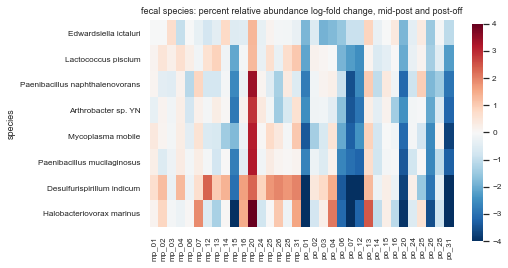

In [4]:
# plot the log-fold longitudinal abundance change (per player) from mid-post and post-off for
# the species which changed significantly (p < 0.05) in abundance from post to off-season timepoint
plot_longitudinal(data_df, SAMPLE_TYPE, TAX_RANK, NONCONCUSSION_PLAYERS)

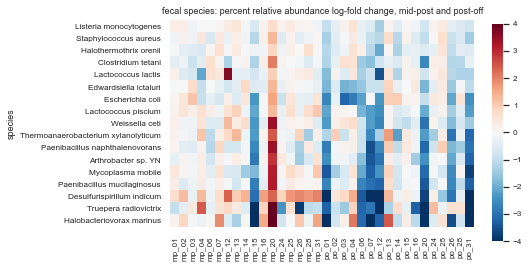

In [5]:
# plot log-fold longitudinal abundance change for an expanded list of species beyond those whose
# adjusted p-value was < 0.05
plot_longitudinal(data_df, SAMPLE_TYPE, TAX_RANK, NONCONCUSSION_PLAYERS,
                  file='football19_data/significant_species_spreadsheets/expanded_significant_species.csv')

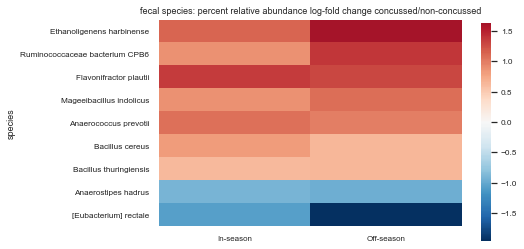

In [6]:
# plot the log-fold abundance difference between concussed and non-concussed players, for the
# species which differed significantly between concussed and non-concussed players at the off-
# season timepoint
plot_concussion(data_df, metadata_df, SAMPLE_TYPE, TAX_RANK)

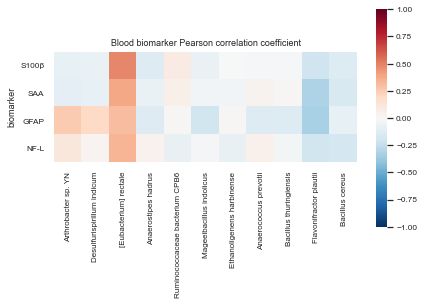

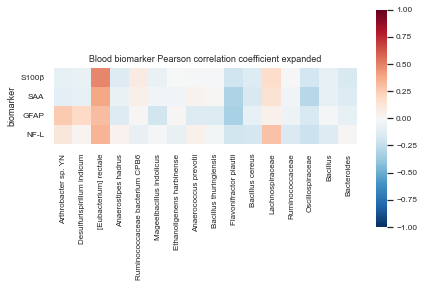

In [7]:
# plot heatmaps showing the correlation between blood biomarkers and bacterial abundance
plot_biomarkers()